In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import norm



# 1. Gathering Data

In [3]:
tickers = ["TSLA"]
yf.pdr_override()
start_date = "2023-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
data = round(web.get_data_yahoo(tickers, start=start_date, end=end_date), 2)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,118.47,118.80,104.64,108.10,108.10,231402800
2023-01-04,109.11,114.59,107.52,113.64,113.64,180389000
2023-01-05,110.51,111.75,107.16,110.34,110.34,157986300
2023-01-06,103.00,114.39,101.81,113.06,113.06,220911100
2023-01-09,118.96,123.52,117.11,119.77,119.77,190284000


In [4]:
short_window_sma = 7
long_window_sma = 90

short_window_ema = 12
long_window_ema = 50

data['SMA_Short'] = data['Close'].rolling(window=short_window_sma).mean().round(2)
data['SMA_Long'] = data['Close'].rolling(window=long_window_sma).mean().round(2)

data['EMA_Short'] = data['Close'].ewm(span=short_window_ema).mean().round(2)
data['EMA_Long'] = data['Close'].ewm(span=long_window_ema).mean().round(2)
#data.Close = data.Close.shift(-1)
#data.dropna(inplace=True)

# 3. Graphical Visualization

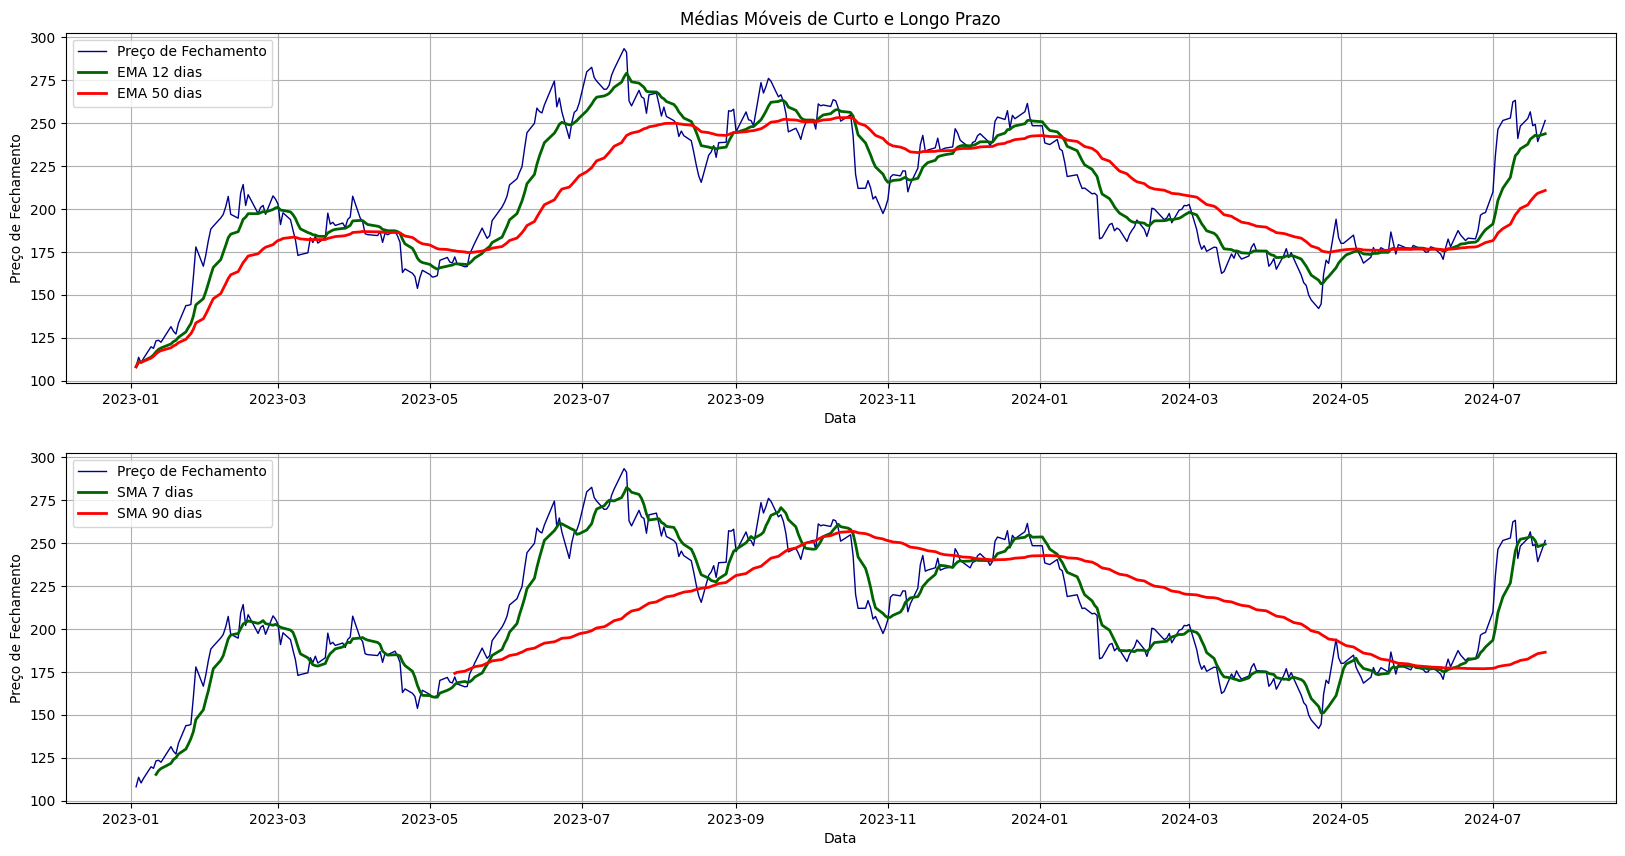

In [5]:
plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.plot(data.index, data['Close'], label='Preço de Fechamento', linewidth=1, color='darkblue')

plt.plot(data.index, data['EMA_Short'], label=f'EMA {short_window_ema} dias', linewidth=2, color='darkgreen')
plt.plot(data.index, data['EMA_Long'], label=f'EMA {long_window_ema} dias', linewidth=2, color='red')

plt.title("Médias Móveis de Curto e Longo Prazo")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(data.index, data['Close'], label='Preço de Fechamento', linewidth=1, color='darkblue')
plt.plot(data.index, data['SMA_Short'], label=f'SMA {short_window_sma} dias', linewidth=2, color='darkgreen')
plt.plot(data.index, data['SMA_Long'], label=f'SMA {long_window_sma} dias', linewidth=2, color='red')
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.grid(True)
plt.show()

# 4. Defining Functions

In [2]:
def check_moving_average(ticker, start_date, end_date, bool_plot_graphs, short_window, long_window, mode, graph_mode):    
    yf.pdr_override()
    data = round(web.get_data_yahoo(ticker, start=start_date, end=end_date), 2) 
    data = data[['Adj Close']]

    if mode == "sma":
        data['SMA_Short'] = data['Adj Close'].rolling(window=short_window).mean().round(2)
        data['SMA_Long'] = data['Adj Close'].rolling(window=long_window).mean().round(2)
    
    elif mode == "ema":
        data['EMA_Short'] = data['Adj Close'].ewm(span=short_window).mean().round(2)
        data['EMA_Long'] = data['Adj Close'].ewm(span=long_window).mean().round(2)
        
    data.dropna(inplace=True)
    if bool_plot_graphs: 
        if graph_mode == "matplot":
            plot_moving_average(data, short_window, long_window, mode)
        elif graph_mode == "plotly":
            plot_moving_average_plotly(data, short_window, long_window, mode)
        

def plot_moving_average(data, short_window, long_window, mode):
    if mode == "sma":
        str_short = "SMA_Short"
        str_long = "SMA_Long"
    
    elif mode == "ema":
        str_short = "EMA_Short"
        str_long = "EMA_Long"
        
    plt.figure(figsize=(20, 15))
    plt.subplot(2,1,1)
    plt.plot(data.index, data['Adj Close'], label='Preço de Fechamento', linewidth=1, color='green')
    
    plt.plot(data.index, data[str_short], label=f'{str_short[:3]} {short_window} dias', linewidth=1, color='blue')
    plt.plot(data.index, data[str_long], label=f'{str_short[:3]} {long_window} dias', linewidth=1, color='orange')
    
    # Adicionando pontos de compra (verde) e venda (vermelho)
    buy_signals = data[(data[str_short] > data[str_long]) & (data[str_short].shift(1) <= data[str_long].shift(1))]
    sell_signals = data[(data[str_short] < data[str_long]) & (data[str_short].shift(1) >= data[str_long].shift(1))]
    
    plt.scatter(buy_signals.index, data.loc[buy_signals.index, str_short], marker='^', color='green', label='Compra')
    plt.scatter(sell_signals.index, data.loc[sell_signals.index, str_short], marker='v', color='red', label='Venda')
    
    plt.title("Médias Móveis de Curto e Longo Prazo com Pontos de Compra e Venda")
    plt.xlabel("Data")
    plt.ylabel("Preço de Fechamento")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_moving_average_plotly(data, short_window, long_window, mode):
    if mode == "sma":
        str_short = "SMA_Short"
        str_long = "SMA_Long"
    
    elif mode == "ema":
        str_short = "EMA_Short"
        str_long = "EMA_Long"
        
    # Criação do gráfico interativo usando Plotly
    fig = go.Figure()
    
    # Linha de preço de fechamento
    fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], mode='lines', name='Preço de Fechamento', line=dict(color='green', width=1)))
    
    # Linha da média móvel curta
    fig.add_trace(go.Scatter(x=data.index, y=data[str_short], mode='lines', name=f'{str_short[:3]} {short_window} dias', line=dict(color='blue', width=1)))
    
    # Linha da média móvel longa
    fig.add_trace(go.Scatter(x=data.index, y=data[str_long], mode='lines', name=f'{str_short[:3]} {long_window} dias', line=dict(color='orange', width=1)))
    
    # Pontos de compra (verde) e venda (vermelho)
    buy_signals = data[(data[str_short] > data[str_long]) & (data[str_short].shift(1) <= data[str_long].shift(1))]
    sell_signals = data[(data[str_short] < data[str_long]) & (data[str_short].shift(1) >= data[str_long].shift(1))]
    
    fig.add_trace(go.Scatter(x=buy_signals.index, y=data.loc[buy_signals.index, str_short], mode='markers', marker=dict(symbol='triangle-up', color='green', size=10), name='Compra'))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=data.loc[sell_signals.index, str_short], mode='markers', marker=dict(symbol='triangle-down', color='red', size=10), name='Venda'))
    
    # Layout do gráfico
    fig.update_layout(
        title="Médias Móveis de Curto e Longo Prazo com Pontos de Compra e Venda",
        xaxis_title="Data",
        yaxis_title="Preço de Fechamento",        
        legend=dict(x=1.02, y=1),
        plot_bgcolor='rgba(0,0,0,0)',
        hovermode='x',
        height=600,
        xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
    )
    
    # Exibir o gráfico
    fig.show()

# 5. Running Functions for Companies

[*********************100%%**********************]  1 of 1 completed


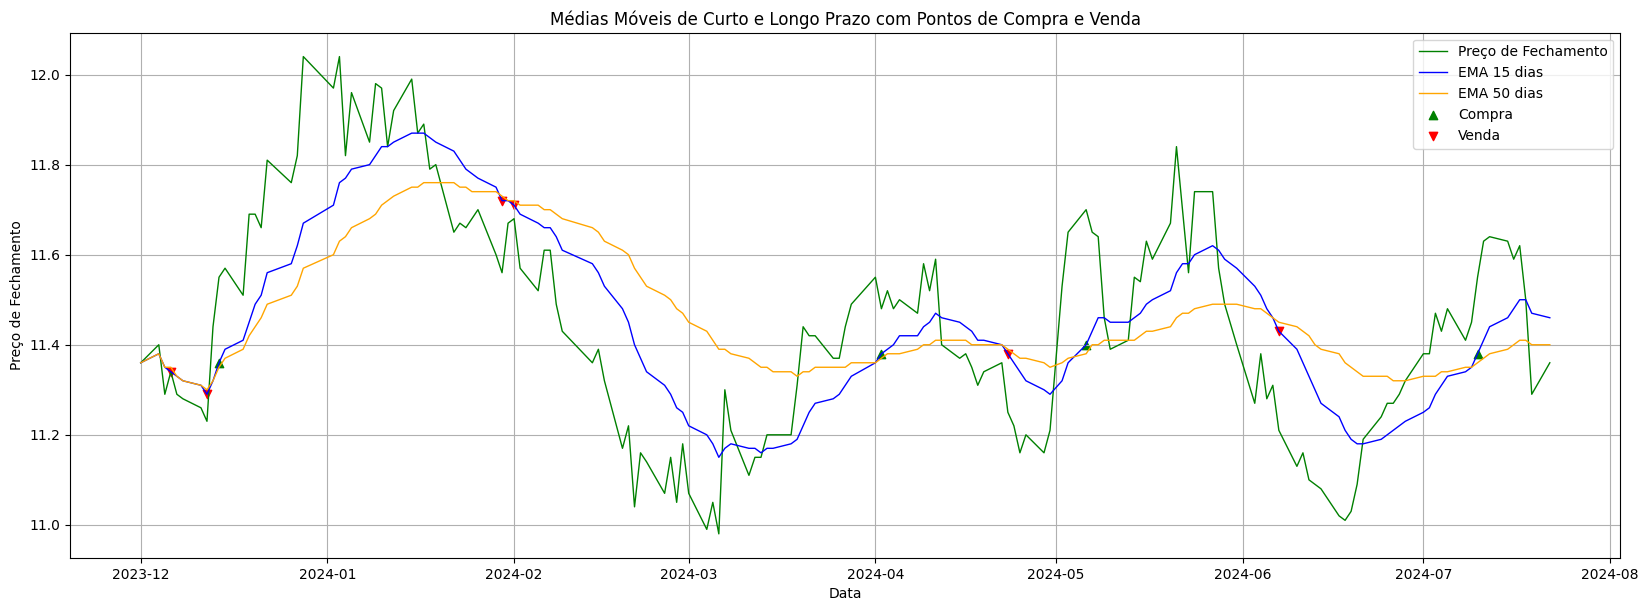

In [11]:
tickers = [
    "TAEE3.SA"
]

for ticker in tickers:
    #Parameters: Ticker, Start Date, End Date, Show All Graphs, Show Graphs, short window, large window, moving average mode (sma or ema), graphic library (matplot or pyplot)
    check_moving_average(ticker, "2023-12-01", datetime.today().strftime('%Y-%m-%d'), True, 15, 50, "ema", "matplot")
    